In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import matplotlib.animation as animation

### HIV Lab Useful Code

In [35]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

### Data Engineering

In [36]:
def get_from_csv(filename):
    data = pd.read_csv(filename,index_col=0)
    return np.ravel(data.to_numpy()), data.index.to_numpy()

In [37]:
#get the data from the prescribed location
T_star, y_star = get_from_csv('../Data/1950_mean_temp.csv')
T_0, y_0 = get_from_csv('../Data/2020_mean_temp.csv')
assert np.allclose(y_star,y_0)

### Define Global Constants and Functions

In [228]:
def gen_a_fun(a_1,a_2,y_vals,M=5):
    """Generate the albedo function given the constants
    """
    def a(eta):
        one = (a_1+a_2)/2
        two = ((a_2-a_1)/2)*np.tanh(M*(y_vals-eta))
        return one+two
    def d_a(eta):
        return -1*(((a_2-a_1)*M)/2)*np.square(1/np.cosh(M*(y_vals-eta)))
    return a, d_a

def s(y):    
    """the s function that siginifies spreading of solar
    radiation/heat across the surface
    """
    return 1 - 0.241*(3*np.square(y)-1)

def T_bar(T):
    """
    Global mean temperature computation
    """
    if (len(T.shape) == 1):
        return np.mean(T)
    else:
        return np.mean(T,axis=1)
    
def T_prime(eta,T, A):
    """
    The T_prime global equation
    """
    in_1 = Q*S_vec*(1-a(eta))
    in_2 = A+B*T
    in_3 = C*(T_bar(T)-T)
    return 1/R*(in_1 - in_2 + in_3)

def T_eta(eta,T):
    """
    For now just use the critical temperature for this condition
    """
    #get the masked y_values
    mask_y = y_star > eta
    y_comp = y_star[mask_y]
    len_add = len(y_star) - len(y_comp)
    #do the case where eta is at the poll
    if (len(y_comp) == 0):
        return T[-1], len(T)-1
    #do the case where eta is at the equator
    elif (len(y_comp) == len(T)):
        return T[0], 0
    else:
        k = np.argmin(y_comp-eta) + len_add
        return (T[k]+T[k-1])/2, k
    
def T_eps_delt(T,k):
    """
    Returns the derivative with respect to T_i of T_eta
    """
    der = list()
    #the outlier cases
    if (k == len(T)-1):
        der = [0 for i in range(len(T))]
        der[-1] = 1
        return np.asarray(der)
    if (k == 0):
        der = [0 for i in range(len(T))]
        der[0] = 1 
        return np.asarray(der)
    #the rest of the cases
    for i in range(len(T)):
        if (k == i or k-1 == i):
            der.append(1/2)
        else:
            der.append(0)
            
    return np.asarray(der)

In [234]:
#define the global constants
N = len(y_star)
n=1000
t_f = 10
time = np.linspace(0,t_f,n)
a_2 = 0.62
a_1 = 0.32
A_0 = 202
eta_0 = 0.9
A_max = 300
A_min = 100
beta = 1.0
gamma = 0.2
B = 1.9
R = 12.6
C = 1.6*B
epsilon = 0.005
Q = 343
T_c = -10
#vector to be held constant
S_vec = s(y_star)
#function dependent on the eta value
a, d_a = gen_a_fun(a_1,a_2,y_star)
state0 = np.concatenate([T_0, np.array([eta_0])])
costate0 = np.zeros_like(state0)

### Solution Computation

In [235]:
def state_equations(t,y,i,A=None):
    """
    Define the state equations for the Budyko Sellers optimal control
    problem defined in the project pdf.
    
    y is the current states (given by bold{T} in the pdf)
    i is index for the global control variable A
    t is the time step
    """
    eta = y[-1]
    T = y[:-1]
    Teta, k = T_eta(eta,T)
    y_new = np.zeros_like(y)
    y_new[:-1] = T_prime(eta,T,A[i])
    y_new[-1] = epsilon*(Teta - T_c)
    return y_new
    
def costate_equations(t,y,i,state=None,A=None):
    """
    Define the costate equations for the Budyko Sellers optimal control
    problem defined in the project pdf.
    
    y is the current costates (given by bold{p} in the pdf)
    i is index for the global control variable A
    t is the time step
    """
    j = n-1-i
    eta = state[j,-1]
    T = state[j,:-1]
    Teta,k = T_eta(eta,T)
    TEpsDelt = T_eps_delt(T,k)
    y_new = np.zeros_like(y)
    T_pri = T_prime(eta,T,A[j])
    part_1 = (B+C)*(y[:-1] - 2*beta*T_pri)
    part_2 = np.mean(C*(2*beta*T_pri - y[:-1]))
    y_new[:-1] = -(1/R*(part_1+part_2)+2*gamma*(T-T_star)
                  -y[-1]*epsilon*TEpsDelt)
    y_new[-1] = -Q/R*np.sum(d_a(eta)*S_vec*(y[:-1]-2*beta*T_pri))
    return y_new

In [236]:
def run_solution_method(tol=1e-4, maxiter=1000, n=10, t_f=50, A=None):
    #intialize the convergence boolean
    conv_bool = False
    cyclical = False
    old_norm = None
    for i in range(maxiter):
        A_old = A.copy()
        #solve the state equations with forward iteration
        new_state_equations = partial(state_equations, A=A_old)
        state = RK4(new_state_equations,state0,0,t_f,n)
        new_costate_equations = partial(costate_equations, state=state, A=A_old)
        #solve the costate equations with backwards iteration
        costate = RK4(new_costate_equations,costate0,0,t_f,n)[::-1]
        #solve for A using the equation derived in pdf (Equation 11)
        one = -costate[:,:-1]*R/(2*beta)
        a_total = np.asarray([a(eta) for eta in state[:,-1]])
        two = Q*S_vec*(1-a_total)
        three = -B*state[:,:-1]
        four = C*(T_bar(state[:,:-1])-state[:,:-1].T).T
        A_star = np.mean((one+two+three+four),axis=1)
        A_star = np.minimum(np.maximum(A_min,A_star),A_max)
        A = 0.5*(A_star + A_old)
        #create the stopping condition
        norm_val = np.linalg.norm(A_old-A)
        print(norm_val)
        if (old_norm is None):
            old_norm = np.zeros_like(norm_val)
        if (norm_val < tol):
            conv_bool = True
            break     
        if (np.absolute(old_norm-norm_val) < tol):
            cyclical = True
            break
            
        old_norm = norm_val
            
    return A, conv_bool, cyclical, state

In [237]:
A = A_0*np.ones(n)
A_fix, conv_bool, cyclical, state = run_solution_method(n=n, maxiter=100, t_f=t_f, A=A)

1376.1864075563549
1658.0534264903506
1558.983539815361
1489.8077967543588
1507.2604757100157
1529.048018874337
1521.9441548042173
1515.8732690642826
1517.5639608215893
1519.4144846939616
1518.8372003282636
1518.3333237021768
1518.4776758518772
1518.6313363977679
1518.575220036804
1518.5241930499235
1518.5433584427017
1518.564925500111
1518.5584343547898
1518.5516774757725
1518.5530792215834
1518.5545934740846
1518.554279841633
1518.5539589728876
1518.5540258747608


False
True


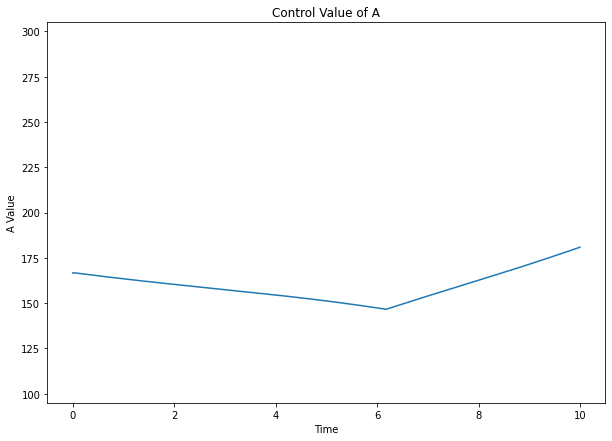

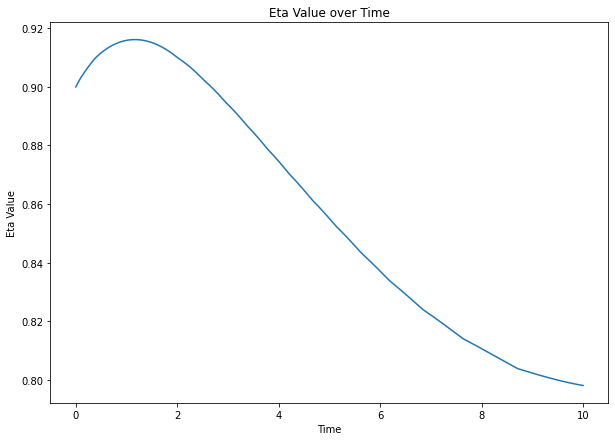

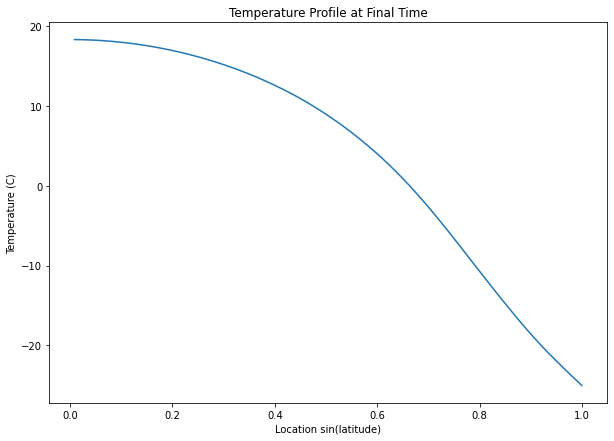

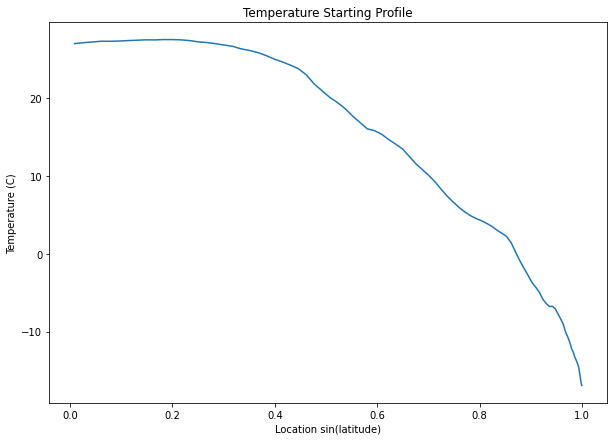

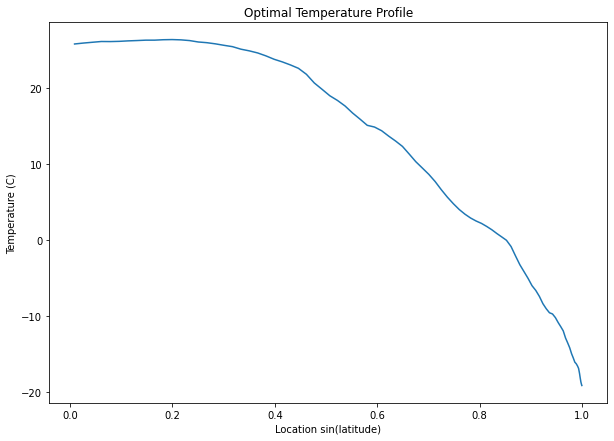

In [238]:
print(conv_bool)
print(cyclical)
#plot the control solution
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(time, A_fix)
ax.set_title("Control Value of A")
ax.set_xlabel("Time")
ax.set_ylabel("A Value")
ax.set_ylim([A_min-5,A_max+5])
plt.show()
#plot the eta solution
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(time, state[:,-1])
ax.set_title("Eta Value over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Eta Value")
plt.show()
#plot the temperature profile at a certain time
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, state[-1,:-1])
ax.set_title("Temperature Profile at Final Time")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()
#plot the starting temperature profile
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, T_0)
ax.set_title("Temperature Starting Profile")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()
#plot the optimal temperature profile
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(y_star, T_star)
ax.set_title("Optimal Temperature Profile")
ax.set_xlabel("Location sin(latitude)")
ax.set_ylabel("Temperature (C)")
plt.show()

In [126]:
#animate temperature profile